In [1]:
import africanus
import casacore.tables.table as table

import numpy as np
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import numpy as np

from scipy.special import jv

from dask.diagnostics import ProgressBar
import dask
import dask.array as da
from daskms import xds_from_ms, xds_from_table, xds_to_table
from africanus.coordinates.dask import radec_to_lm
from africanus.rime.dask import wsclean_predict
from numpy.random import default_rng, Generator
from typing import Optional

from scipy.special import jv
DIAM = 5
c1=1.091
c4=0.957
c6=-0.139
c11=0.445

def vBz(theta, phi, m, n, lambd):
    r = np.outer(DIAM / (2 * lambd), theta)
    if m>= 0:
        return jv(n+1, 2 * np.pi * r) * np.cos(m*phi) / (np.pi * r)
    else:
        return jv(n+1, 2 * np.pi * r) * np.sin(-m*phi) / (np.pi * r)

In [52]:
freq_arr = (np.arange(8000) * 162.5e3) + 0.7e9

In [53]:
lambd_arr = 2.99792e8/freq_arr

In [54]:
from astropy.coordinates import SkyCoord
import astropy.units as u
pcenter = SkyCoord(ra = 0. * u.deg, dec=37.129833 * u.deg)
src_coord = SkyCoord(ra = 4.02 * u.deg, dec=40.129833 * u.deg)

In [55]:
pcenter.position_angle(src_coord).to(u.deg)

<Angle 45.06934432 deg>

In [56]:
pcenter.separation(src_coord)

<Angle 4.34211948 deg>

In [57]:
theta = pcenter.separation(src_coord).to(u.rad).value
phi = pcenter.position_angle(src_coord).to(u.rad).value

In [58]:
theta

0.0757842814661876

In [59]:
phi

0.7866084500958195

In [109]:
chromatic_beam = (c1 * vBz(theta, phi, 0, 0, lambd_arr) +
             c4 * vBz(theta, phi, 0, 2, lambd_arr) +
             c6 * vBz(theta, phi, 2, 2, lambd_arr) +
             c11 * vBz(theta, phi, 2, 4, lambd_arr))

Text(0, 0.5, 'Voltage beam')

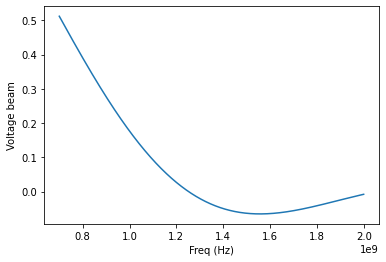

In [110]:
plt.plot(freq_arr, chromatic_beam)
plt.xlabel('Freq (Hz)')
plt.ylabel('Voltage beam')

Text(0, 0.5, 'Power beam')

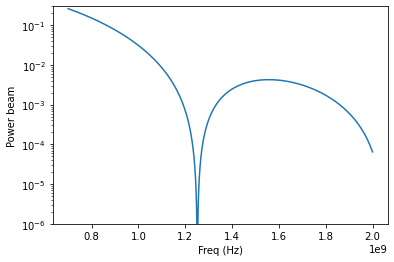

In [111]:
plt.plot(freq_arr, chromatic_beam**2)
plt.yscale('log')
plt.ylim([1e-6, 0.3])
plt.xlabel('Freq (Hz)')
plt.ylabel('Power beam')

In [71]:
np.mean(chromatic_beam**2)

0.031300848633608026

In [68]:
from astropy.coordinates import SkyCoord
import astropy.units as u
pcenter = SkyCoord(ra = 0. * u.deg, dec=37.129833 * u.deg)
src_coord = SkyCoord(ra = 4.02 * u.deg, dec=40.129833 * u.deg)
src_lm = radec_to_lm(da.array([[src_coord.ra.to(u.radian).value, src_coord.dec.to(u.radian).value]]),
                     phase_centre=da.array([pcenter.ra.to(u.radian).value, pcenter.dec.to(u.radian).value]))
writes2 = []
pol_mat = da.array([1, 0, 0, 1]) # this is not 0.5 because there's a factor of 2 in the RIME
for xds in xds_from_ms('/fastpool/data/snapshot-beam-test/W-snapshot-8000chan.ms',
                       columns=["UVW", "ANTENNA1", "ANTENNA2", "TIME"],
                       group_cols=["FIELD_ID", "DATA_DESC_ID"],
                       chunks={"row": 5e3}):
    vis = wsclean_predict(xds['UVW'], src_lm, da.array(['POINT']), da.array([1.0]),
                    da.array([[0]]), da.array([True]), da.array([1.35e9]), da.array([[0,0,0]]), freq_arr)
    vis = vis * da.array(chromatic_beam**2).reshape((8000, 1)) * pol_mat 
    print(vis.shape)
    # Assign visibilities to MODEL_DATA array on the dataset
    xds = xds.assign(DATA=(("row", "chan", "corr"), vis))
    # Create a write to the table
    write2 = xds_to_table(xds, '/fastpool/data/snapshot-beam-test/W-snapshot-8000chan.ms', ['DATA'])
    # Add to the list of writes
    writes2.append(write2)

(2096128, 8000, 4)


In [69]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    dask.compute(writes2)

# Pointing errors
I'll just wiggle the offsets a bit.

In [124]:
def get_pointing_error(error_rms_deg, size, generator: Optional[Generator]=None):
    if not generator:
        generator = default_rng()
    # should be fine since 1 arcmin = 3e-4 rad
    sep_deg = generator.normal(loc=0.0, scale=error_rms_deg/np.sqrt(2), size=size)
    pa_deg = generator.normal(loc=0.0, scale=error_rms_deg/np.sqrt(2), size=size)
    return sep_deg, pa_deg

## Plot 100 beams with pointing offsets

__The simple addition here is wrong except for the pointing center at (0, 0)__

In [125]:
sep_deg, pa_deg = get_pointing_error(0.00166667, 100)
new_sep = theta + (sep_deg/57.2958)
new_pa = phi + (pa_deg/57.2958)
chromatic_beams = (c1 * vBz(new_sep, new_pa, 0, 0, lambd_arr) +
             c4 * vBz(new_sep, new_pa, 0, 2, lambd_arr) +
             c6 * vBz(new_sep, new_pa, 2, 2, lambd_arr) +
             c11 * vBz(new_sep, new_pa, 2, 4, lambd_arr))

In [126]:
new_pa - phi

array([-1.52243616e-05,  1.23419746e-05, -3.74310187e-06, -6.64337630e-06,
       -2.10427732e-06, -1.94654139e-05,  1.02382068e-05,  6.82096029e-06,
        2.55354956e-05, -2.99252348e-05,  3.81054862e-05, -9.53543595e-06,
        1.03123577e-05, -9.68663921e-06, -1.41370084e-05,  8.27440822e-06,
       -1.75299660e-05,  2.81834632e-05,  8.78416934e-06, -3.09133745e-05,
       -1.08541346e-06,  1.41967590e-05,  1.88569568e-06, -7.17812257e-06,
       -3.13992898e-05,  4.92948363e-06, -2.29603870e-06, -2.63890560e-05,
       -6.05539493e-07, -7.06618554e-06,  6.90851331e-06,  2.31123739e-05,
       -1.98659205e-05, -1.31601107e-05, -3.70543984e-05,  3.28449071e-06,
       -3.08322734e-05,  4.04146076e-05, -1.54722951e-05,  1.22434279e-05,
       -1.71247189e-05,  1.07061626e-05,  1.23236841e-05,  2.50346405e-05,
        6.49822663e-06,  1.40340827e-05,  1.95918593e-06,  1.20476506e-05,
        8.89025446e-06,  4.54964199e-05,  1.44141833e-06, -3.04516635e-05,
        3.69954742e-07,  

Text(0, 0.5, 'Voltage beam')

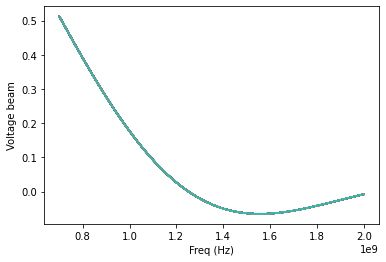

In [127]:
plt.plot(freq_arr, chromatic_beams)
plt.xlabel('Freq (Hz)')
plt.ylabel('Voltage beam')

Text(0, 0.5, 'Power beam')

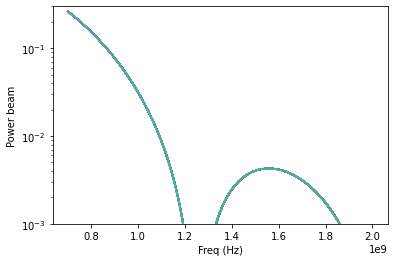

In [128]:
plt.plot(freq_arr, chromatic_beams**2)
plt.yscale('log')
plt.ylim([1e-3, 0.3])
plt.xlabel('Freq (Hz)')
plt.ylabel('Power beam')